In [1]:
import psycopg2
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

#### Connecting to database 

In [5]:
conn = psycopg2.connect(
    host = '165.22.22.202' ,
    database = 'gsmarena' ,
    user = 'anomaly' ,
    password = 'Hitman.agent47'    
)

### BATTERYMAH ~ BRAND ~ DISPLAYSIZE

#### Fetching required tables from database 

In [6]:
cur = conn.cursor()
cur.execute(''' SELECT "BrandName" , "BatterymAh" , "DisplaySize"
                FROM devices
                WHERE "BrandName" IN ('Apple118', 'Xiaomi377' , 'Samsung1383' );''')

rows = cur.fetchall()
col_names = [desc[0] for desc in cur.description]

battery_display = pd.DataFrame(rows, columns=col_names)

In [7]:
battery_display

,BrandName,BatterymAh,DisplaySize
0,Xiaomi377,4250,6.55
1,Xiaomi377,5000,6.67
2,Xiaomi377,5000,6.67
3,Xiaomi377,5160,6.67
4,Xiaomi377,4500,6.28
...,...,...,...
4784,Apple118,1715,4.70
4785,Apple118,2750,5.50
4786,Apple118,1960,4.70
4787,Apple118,2900,5.50


In [11]:
battery_display.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4789 entries, 0 to 4788
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BrandName     4789 non-null   object 
 1   BatterymAh    4789 non-null   int64  
 2   DisplaySize   4789 non-null   float64
 3   DisplayClass  4789 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 149.8+ KB


#### Make display class 

In [8]:
def display_class(x) :
    if x >= 7 :
        return 'LARGE'
    return 'SMALL'

In [10]:
battery_display['DisplayClass'] = battery_display['DisplaySize'].apply(display_class)

/Applications/anaconda3/envs/quera/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='BatterymAh', ylabel='Count'>

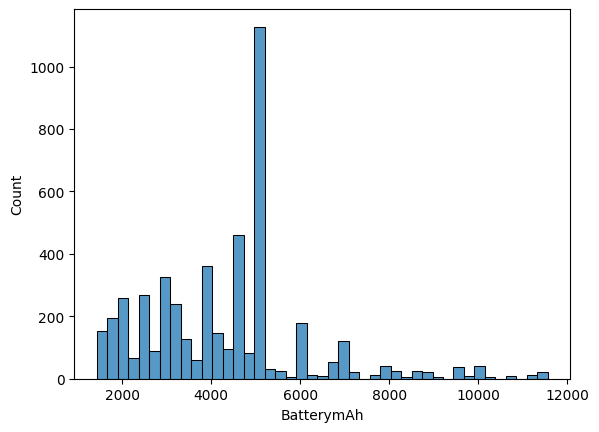

In [12]:
sns.histplot(battery_display['BatterymAh'])

In [19]:
from scipy.stats import normaltest , levene

In [14]:
stat_dagostino, p_value_dagostino = normaltest(battery_display['BatterymAh'])
print(f"D'Agostino-Pearson Test of : Statistics={stat_dagostino}, p-value={p_value_dagostino}")

D'Agostino-Pearson Test of : Statistics=887.1522605444709, p-value=2.2768494691673095e-193


#### Make batterymah normal 

In [15]:
from scipy.stats import yeojohnson , boxcox 

In [16]:
battery_display['Normal_Battery'] = yeojohnson(battery_display['BatterymAh'])[0]

/Applications/anaconda3/envs/quera/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Normal_Battery', ylabel='Count'>

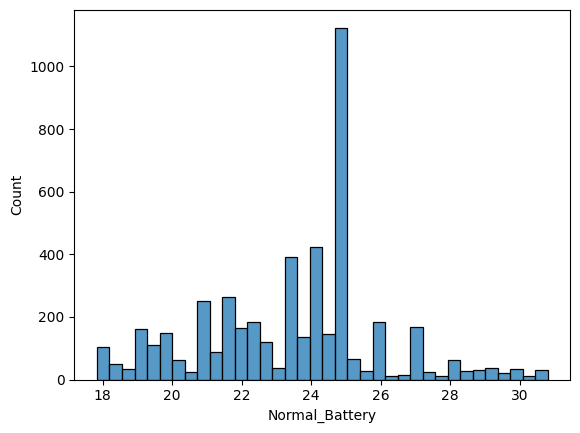

In [17]:
sns.histplot(battery_display['Normal_Battery'])

In [18]:
stat_dagostino, p_value_dagostino = normaltest(battery_display['Normal_Battery'])
print(f"D'Agostino-Pearson Test of : Statistics={stat_dagostino}, p-value={p_value_dagostino}")

D'Agostino-Pearson Test of : Statistics=0.009896453131817987, p-value=0.9950639957392763


In [23]:
_, p_value = levene(
    battery_display[battery_display['BrandName'] == 'Apple118']['Normal_Battery'] , 
    battery_display[battery_display['BrandName'] == 'Xiaomi377']['Normal_Battery'] , 
    battery_display[battery_display['BrandName'] == 'Samsung1383']['Normal_Battery']
)
p_value

1.3646501692497779e-227

In [24]:
battery_display['Normal_Battery'] = boxcox(battery_display['BatterymAh'])[0]

/Applications/anaconda3/envs/quera/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Normal_Battery', ylabel='Count'>

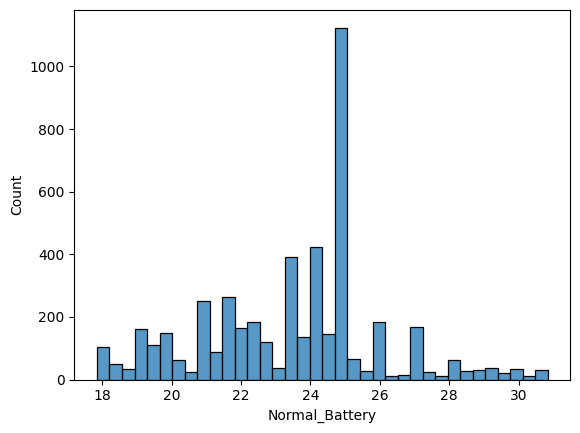

In [25]:
sns.histplot(battery_display['Normal_Battery'])

In [26]:
stat_dagostino, p_value_dagostino = normaltest(battery_display['Normal_Battery'])
print(f"D'Agostino-Pearson Test of : Statistics={stat_dagostino}, p-value={p_value_dagostino}")

D'Agostino-Pearson Test of : Statistics=0.010078133511911799, p-value=0.9949736080422744


In [27]:
_, p_value = levene(
    battery_display[battery_display['BrandName'] == 'Apple118']['Normal_Battery'] , 
    battery_display[battery_display['BrandName'] == 'Xiaomi377']['Normal_Battery'] , 
    battery_display[battery_display['BrandName'] == 'Samsung1383']['Normal_Battery']
)
p_value

1.3622760698087184e-227

#### ANOVA TwoWay

In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

One-way ANOVA results:
                    sum_sq      df            F         PR(>F)
brand          3823.990745     2.0   506.798167  2.371881e-200
classs        10924.913032     1.0  2895.784155   0.000000e+00
brand:classs    899.516484     2.0   119.214019   2.986130e-51
Residual      18044.804526  4783.0          NaN            NaN


<Axes: xlabel='brand', ylabel='battery'>

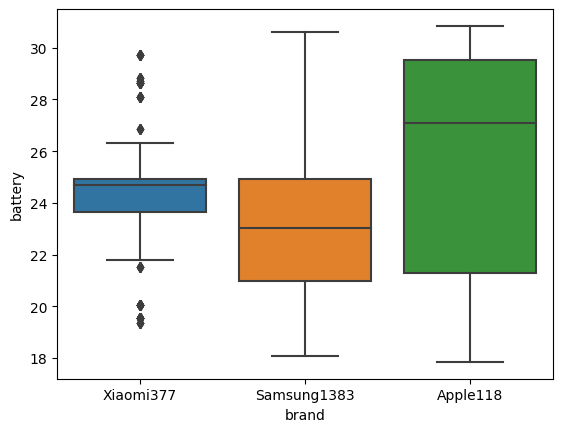

In [31]:
OTANOVA ={"battery": battery_display['Normal_Battery'], "brand" : battery_display['BrandName'], "classs": battery_display['DisplayClass']}
OTANOVA =  pd.DataFrame(OTANOVA)
model = ols('battery ~ brand * classs', data=OTANOVA).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("One-way ANOVA results:")
print(anova_table)
sns.boxplot(x='brand', y='battery', data=OTANOVA)